In [ ]:
# !pip install --ignore-installed --upgrade tensorflow
# !pip install keras 
!pip install pip install cond-rnn


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from datetime import datetime
from datetime import date
from tqdm import tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from cond_rnn import ConditionalRNN
from tensorflow.keras import backend as K


In [ ]:
path = ""

In [ ]:
# # Uncomment this if you are using colab
# path = "/content/drive/MyDrive/209 Project/"
# from google.colab import drive 
# drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# load data
X_temp_train = np.load(path + "data/train_temp.npy", )
X_temp_val = np.load(path + "data/val_temp.npy")
X_temp_test = np.load(path + "data/test_temp.npy")

X_static_train = np.load(path + "data/train_static.npy", )
X_static_val = np.load(path + "data/val_static.npy")
X_static_test = np.load(path + "data/test_static.npy")

y_train = np.load(path + "data/train_y.npy", )
y_val = np.load(path + "data/val_y.npy")
y_test = np.load(path + "data/test_y.npy")

print(X_temp_train.shape, X_static_train.shape, y_train.shape)

(246744, 28, 5) (246744, 8) (246744, 1)


In [ ]:
timesteps = X_temp_train.shape[1]
n_temp_features= X_temp_train.shape[2]
n_static_features = X_static_train.shape[1]

## Build Model

In [ ]:
input_temp = tf.keras.Input(name='in_temp',shape=(timesteps,n_temp_features)) 

input_static = tf.keras.Input(name='in_static', shape=[n_static_features]) 
cond = ConditionalRNN(32, cell='LSTM', return_sequences=True)([input_temp, input_static]) #return_sequences=True
dropout_cond = tf.keras.layers.Dropout(0.2)(cond)

predictions = tf.keras.layers.Dense(1)(dropout_cond)

model = tf.keras.Model(inputs=[input_temp, input_static], outputs=predictions) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_static (InputLayer)          [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(1, None, 8)]       0           in_static[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Tile (TensorFlowOpL [(2, None, 8)]       0           tf_op_layer_ExpandDims[0][0]     
__________________________________________________________________________________________________
dense (Dense)                   (2, None, 32)        288         tf_op_layer_Tile[0][0]           
_______________________________________________________________________________________

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20), #]
            ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6)]
            
model.compile(optimizer='adam', loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit([X_temp_train,X_static_train], y_train, 
          epochs = 200, 
          batch_size = 128, 
          validation_data=([X_temp_val,X_static_val], y_val), 
          callbacks=callbacks)


Epoch 1/200
1928/1928 [==============================] - 39s 20ms/step - loss: 0.5929 - root_mean_squared_error: 0.7700 - val_loss: 0.5598 - val_root_mean_squared_error: 0.7482
Epoch 2/200
1928/1928 [==============================] - 39s 20ms/step - loss: 0.5010 - root_mean_squared_error: 0.7078 - val_loss: 0.5476 - val_root_mean_squared_error: 0.7400
Epoch 3/200
1928/1928 [==============================] - 39s 20ms/step - loss: 0.4856 - root_mean_squared_error: 0.6968 - val_loss: 0.5353 - val_root_mean_squared_error: 0.7316
Epoch 4/200
1928/1928 [==============================] - 39s 20ms/step - loss: 0.4755 - root_mean_squared_error: 0.6896 - val_loss: 0.5332 - val_root_mean_squared_error: 0.7302
Epoch 5/200
1928/1928 [==============================] - 39s 20ms/step - loss: 0.4682 - root_mean_squared_error: 0.6843 - val_loss: 0.5207 - val_root_mean_squared_error: 0.7216
Epoch 6/200
1928/1928 [==============================] - 39s 20ms/step - loss: 0.4622 - root_mean_squared_error: 0.

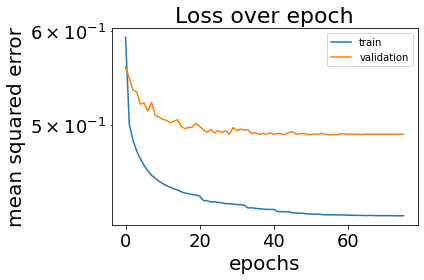

In [ ]:
# Plot loss over epochs
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.semilogy(history.history["loss"], label = "train")
plt.semilogy(history.history["val_loss"], label = "validation")
plt.title("Loss over epoch",fontsize=22)
plt.legend()
plt.ylabel("mean squared error", fontsize=20)
plt.xlabel("epochs" , fontsize=20)
plt.tight_layout()
plt.savefig(path + "graphs/loss.png", dpi = 200)

In [ ]:
# Save model result
pred_y = model.predict([X_temp_test,X_static_test])[:,0,0]
np.save(path + "data/pred_result", pred_y)
print(pred_y.shape)

(83142,)
